You can run this notebook in a [live session](https://mybinder.org/v2/gh/aaronspring/climpred_egu22_demo/HEAD?labpath=EGU22.ipynb) [<img src="https://mybinder.org/badge_logo.svg" alt='binder badge'>](https://mybinder.org/v2/gh/aaronspring/climpred_egu22_demo/HEAD?labpath=EGU22.ipynb) or view it [on Github](https://github.com/aaronspring/climpred_egu22_demo/blob/main/EGU22.ipynb).

# `climpred` live demo at `EGU22`

<img src="climpred_logo.png" alt="climpred_logo" height=200 width=700> <img src="https://egu22.eu/template_egu22_logo.svg" alt="EGU22" height=200 width="500">

Presentation Title: [`climpred`: weather and climate forecast verification in python](https://meetingorganizer.copernicus.org/EGU22/EGU22-8200.html)

Aaron Spring | Thursday, 26 May 2022 15:24–15:31 | Room 0.94/95 | Vienna

Abstract: [EGU22-8200](https://meetingorganizer.copernicus.org/EGU22/EGU22-8200.html)

---

Session: [NP5.1 Advances in statistical post-processing, blending and verification of deterministic and ensemble forecasts](https://meetingorganizer.copernicus.org/EGU22/session/42639)

Thursday, 26 May 2022, 15:00–17:00 | Presentations | 15:10–16:40 | Room 0.94/95 | 

Abstract: [NP5.1](https://meetingorganizer.copernicus.org/EGU22/session/42639)

---
---

Predicting subseasonal to seasonal weather and climate yields numerous benefits for economic and environmental decision-making.
Forecasters verify the forecast quality of models by initializing large sets of retrospective forecasts to predict past variations and phenomena in hindcast studies.

Quantifying prediction skill for multi-dimensional geospatial model output is computationally expensive and a difficult coding challenge. The large datasets require parallel and out-of-memory computing to be analyzed efficiently. Further, aligning the many forecast initializations with differing observational products is a straight-forward, but exhausting and error-prone exercise for researchers.

To simplify and standardize forecast verification across scales from hourly weather to decadal climate forecasts, we built climpred: a python package for computationally efficient and methodologically consistent verification of ensemble prediction models. We rely on the python software ecosystem developed by the open pangeo geoscience community. We leverage NetCDF metadata using [`xarray`](https://docs.xarray.dev/en/stable/) and out-of-core computation parallelized with [`dask`](https://docs.dask.org/en/latest/array.html) to scale analyses from a laptop to supercomputer.

With [`climpred`](https://climpred.readthedocs.io/en/stable/index.html), researchers can assess forecast quality from a large set of metrics (including [`cprs`](https://climpred.readthedocs.io/en/stable/metrics.html?continuous-ranked-probability-score-crps#continuous-ranked-probability-score-crps), [`rps`](https://climpred.readthedocs.io/en/stable/metrics.html?continuous-ranked-probability-score-crps#ranked-probability-score), [`rank_histogram`](https://climpred.readthedocs.io/en/stable/metrics.html?continuous-ranked-probability-score-crps#rank-histogram), [`reliability`](https://climpred.readthedocs.io/en/stable/metrics.html?continuous-ranked-probability-score-crps#reliability), [`contingency`](https://climpred.readthedocs.io/en/stable/metrics.html#contingency-based-metrics), [`bias`](https://climpred.readthedocs.io/en/stable/metrics.html#rmse), [`acc`](https://climpred.readthedocs.io/en/stable/metrics.html#pearson-product-moment-correlation-coefficient), ...) in just a few lines of code.

This simplified and standardized process frees up resources to tackle the large process-based unknowns in predictability research. Here, we perform a live and interactive multi-model comparison removing bias with different methodologies from [NMME project](http://iridl.ldeo.columbia.edu/expert/SOURCES/.Models/.NMME/) hindcasts and compare against `persistence` and `climatology` [`reference`](https://climpred.readthedocs.io/en/stable/reference_forecast.html) forecasts.

In [1]:
import climpred
import warnings

warnings.simplefilter("ignore")
import xarray as xr
import matplotlib.pyplot as plt

v = "sst"

from climpred import HindcastEnsemble

In [2]:
initialized = climpred.tutorial.load_dataset("NMME_hindcast_Nino34_sst")
obs = climpred.tutorial.load_dataset("NMME_OIv2_Nino34_sst")

hindcast = climpred.HindcastEnsemble(initialized).add_observations(obs)
hindcast # HindcastEnsemble is add dict of xr.Datasets

<climpred.HindcastEnsemble>
Initialized:
    sst      (model, init, lead, member) float64 nan nan nan nan ... nan nan nan
Uninitialized:
    None
Observations:
    sst      (time) float64 26.06 26.26 26.72 26.7 ... 25.77 25.3 25.34 25.53

<AxesSubplot:xlabel='validity time', ylabel='Sea Surface Temperature\n[Celsius_scale]'>

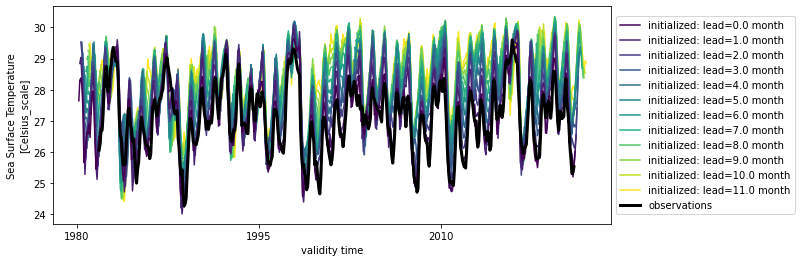

In [3]:
# easy plotting function for 1-var HindcastEnsemble with only dimensions init, lead, member
hindcast.sel(model="GFDL-CM2p5-FLOR-A06").plot()

## Additive mean bias removal

Typically, bias depends on lead-time and should therefore also be removed depending on `lead`. Set `dim=[]` to no aggregate over any time dimension, so later `groupby` is possible.

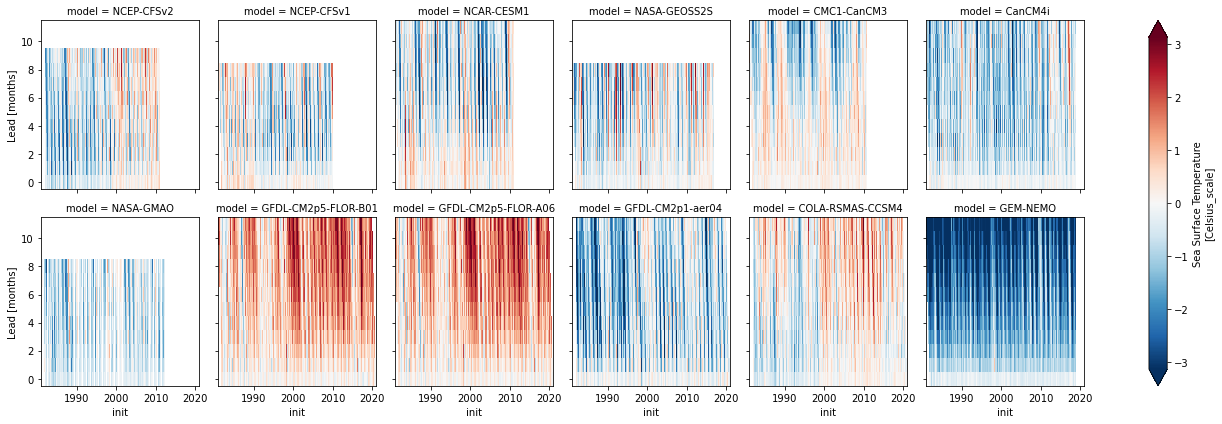

In [4]:
bias = hindcast.verify(
    metric="additive_bias", comparison="e2o", dim=[], alignment="same_verifs"
)

bias[v].plot(col="model", col_wrap=6, robust=True)

In [5]:
# group bias by seasonality
seasonality = climpred.options.OPTIONS["seasonality"]
seasonality

'month'

In [6]:
bias = hindcast.verify(metric="additive_bias", comparison="e2o", dim=[], alignment="same_verifs")
bias

<xarray.Dataset>
Dimensions:     (init: 481, lead: 12, model: 12)
Coordinates:
  * init        (init) object 1980-12-01 00:00:00 ... 2020-12-01 00:00:00
  * lead        (lead) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
  * model       (model) object 'NCEP-CFSv2' 'NCEP-CFSv1' ... 'GEM-NEMO'
    valid_time  (lead, init) object nan nan nan nan nan ... nan nan nan nan nan
    skill       <U11 'initialized'
Data variables:
    sst         (lead, model, init) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:                   IRIDL
    source:                        http://iridl.ldeo.columbia.edu/SOURCES/.Mo...
    postprocessed:                 https://gist.github.com/aaronspring/94e24f...
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_members:             24
    alignment:                     same_verifs
    metric:                        unconditional_bias
    comparison:                    e2o
    dim:                           []
    reference:                     []

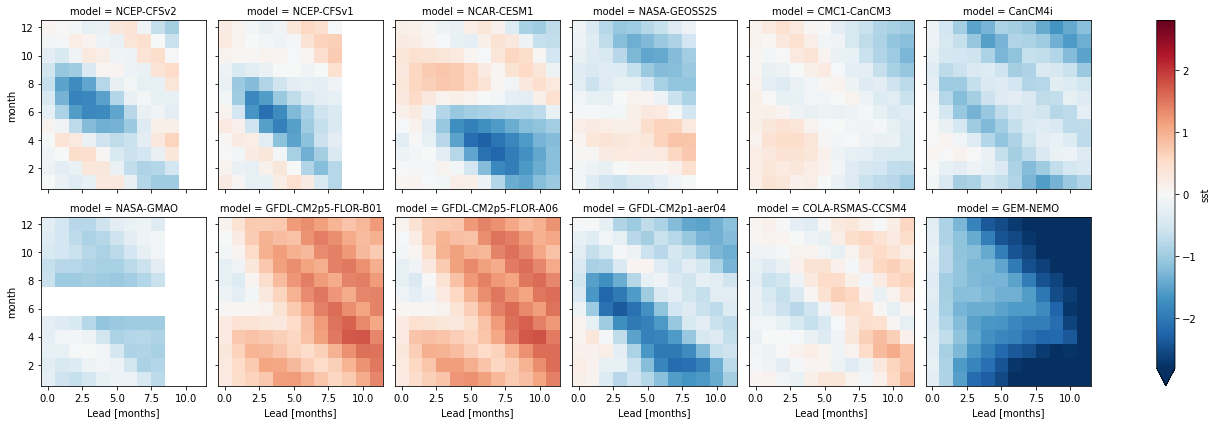

In [7]:
bias.groupby(f"init.{seasonality}").mean()[v].plot(col="model", col_wrap=6, robust=True)

## `train_test_split`

[Risbey et al. 2021](http://www.nature.com/articles/s41467-021-23771-z) demonstrate how important a clean separation of a `train` and a `test` period is for bias reduction. 

Implemented `train_test_split`s in [`HindcastEnsemble.remove_bias()`](https://climpred.readthedocs.io/en/stable/bias_removal.html):

- `unfair`: completely overlapping `train` and `test` (climpred default)
- `unfair-cv`: overlapping `train` and `test` except for current `init`, which is [left out](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) (set `cv="LOO"`)
- `fair`: no overlap between `train` and `test` (recommended)

In [8]:
metric_kwargs = dict(
    metric="rmse",  # https://climpred.readthedocs.io/en/stable/metrics.html
    alignment="same_verifs",  # https://climpred.readthedocs.io/en/stable/alignment.html
    dim="init",  # https://climpred.readthedocs.io/en/latest/examples/decadal/verify_dim_implications.html
    comparison="e2o",  # https://climpred.readthedocs.io/en/stable/comparisons.html
    skipna=True,  # passed to metric https://xskillscore.readthedocs.io/en/stable/api/xskillscore.rmse.html#xskillscore.rmse
)

<AxesSubplot:xlabel='validity time', ylabel='Sea Surface Temperature\n[Celsius_scale]'>

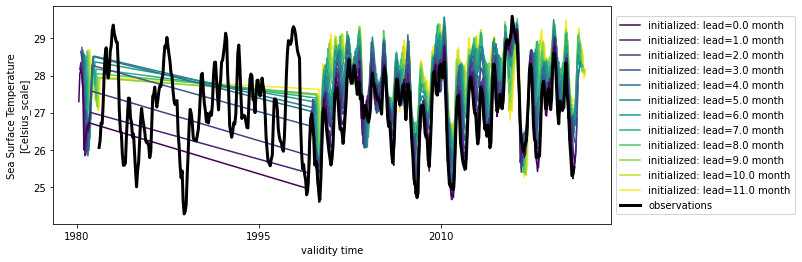

In [9]:
# fair calculates bias for train_time/train_init and drops these indices from hindcast
hindcast.remove_bias(
    how="additive_mean",
    alignment=metric_kwargs["alignment"],
    train_test_split="fair",
    train_time=slice("1982", "1998"),
).sel(model="GFDL-CM2p5-FLOR-A06").plot()

In [10]:
train_test_split = ["unfair", "unfair-cv", "fair"]  # different train_test_split methods to compare
verify_init = slice("1999", None)
skill_train_test_split = [hindcast.sel(init=verify_init).verify(**metric_kwargs)]
skill_train_test_split.append(
    hindcast.remove_bias(
        how="additive_mean",
        alignment=metric_kwargs["alignment"],
        train_test_split="unfair",
    ).sel(init=verify_init).verify(**metric_kwargs)
)
skill_train_test_split.append(
    hindcast.remove_bias(
        how="additive_mean",
        alignment=metric_kwargs["alignment"],
        train_test_split="unfair-cv",
        cv="LOO",  # leave-one-out
    ).sel(init=verify_init).verify(**metric_kwargs)
)
skill_train_test_split.append(
    hindcast.remove_bias(
        how="additive_mean",
        alignment=metric_kwargs["alignment"],
        train_test_split="fair",
        train_time=slice("1982", "1998"),
    ).sel(init=verify_init).verify(**metric_kwargs)
)

skill_train_test_split = xr.concat(skill_train_test_split, "train_test_split")[v].assign_coords(train_test_split=["None"] + train_test_split)

In [11]:
import seaborn as sns
sns.set_palette("husl", skill_train_test_split.model.size)

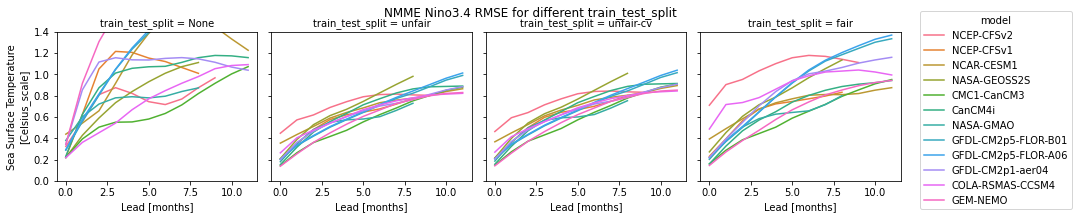

In [12]:
# plotting an xr.DataArray https://xarray.pydata.org/en/stable/generated/xarray.plot.FacetGrid.html
skill_train_test_split.plot(hue="model", col="train_test_split", x="lead")
plt.ylim([0, 1.4])
plt.suptitle(f"NMME Nino3.4 {metric_kwargs['metric'].upper()} for different train_test_split", y=1.0)
plt.savefig(f"NMME_Nino34_{metric_kwargs['metric'].upper()}_train_test_split.png",dpi=150, facecolor='white')

## Comparison of methods `how`

[`HindcastEnsemble.remove_bias()`](https://climpred.readthedocs.io/en/stable/api/climpred.classes.HindcastEnsemble.remove_bias.html#climpred.classes.HindcastEnsemble.remove_bias)

In [13]:
methods = [
    "additive_mean",
    # "multiplicative_std",
    "DetrendedQuantileMapping",
    "EmpiricalQuantileMapping",
    # "PrincipalComponents",
    # "LOCI",
    "QuantileDeltaMapping",
    "Scaling",
    "modified_quantile",
    "basic_quantile",
    # "gamma_mapping",
    # "normal_mapping",
]

In [14]:
# xclim.sdba requires pint units
hindcast._datasets["initialized"][v].attrs["units"] = "C"
hindcast._datasets["observations"][v].attrs["units"] = "C"

In [15]:
metric_kwargs["alignment"] = "same_inits" # see https://climpred.readthedocs.io/en/stable/alignment.html
metric_kwargs["reference"] = ["climatology", "persistence"] # compare against climatology skill and persistence skill

In [16]:
skill_bias_reduction = [hindcast.sel(init=slice("1999", None)).verify(**metric_kwargs)]
for method in methods:
    skill_bias_reduction.append(
        hindcast.remove_bias(
            how=method,
            alignment=metric_kwargs["alignment"],
            train_test_split="fair",
            train_init=slice("1982", "1998"),
        ).verify(**metric_kwargs)
    )
skill_bias_reduction = xr.concat(skill_bias_reduction, "bias_correction")[v].assign_coords(bias_correction=["None"] + methods)

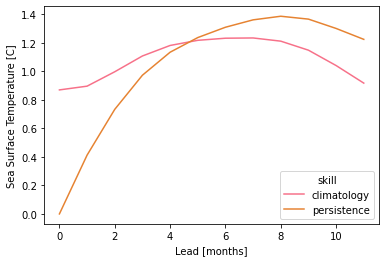

In [17]:
# reference forecasts are unaffected by bias_correction
refs = skill_bias_reduction.drop_sel(skill="initialized").isel(
    bias_correction=0, model=0, drop=True
)
refs.plot(hue="skill")

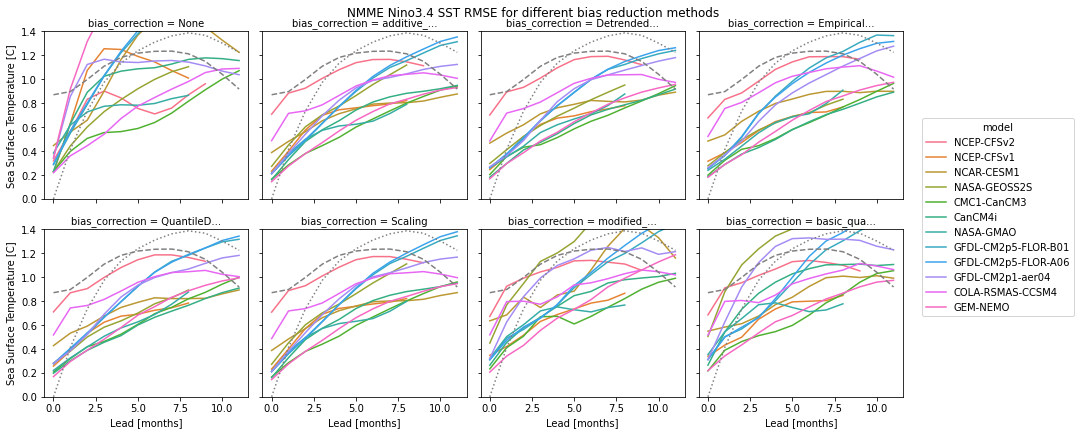

In [18]:
fg = skill_bias_reduction.sel(skill="initialized").plot(
    hue="model", col="bias_correction", x="lead", col_wrap=4
)
plt.ylim([0, 1.4])
plt.suptitle(f"NMME Nino3.4 SST {metric_kwargs['metric'].upper()} for different bias reduction methods", y=1.0)
for ax in fg.axes.flatten():
    ax.plot(refs.sel(skill="persistence"), color="gray", ls=":")
    ax.plot(refs.sel(skill="climatology"), color="gray", ls="--")
plt.savefig(f"NMME_Nino34_{metric_kwargs['metric'].upper()}_bias_correction_methods.png",dpi=150, facecolor='white')

#### How many months better than reference forecasts?

(0.0, 1.5)

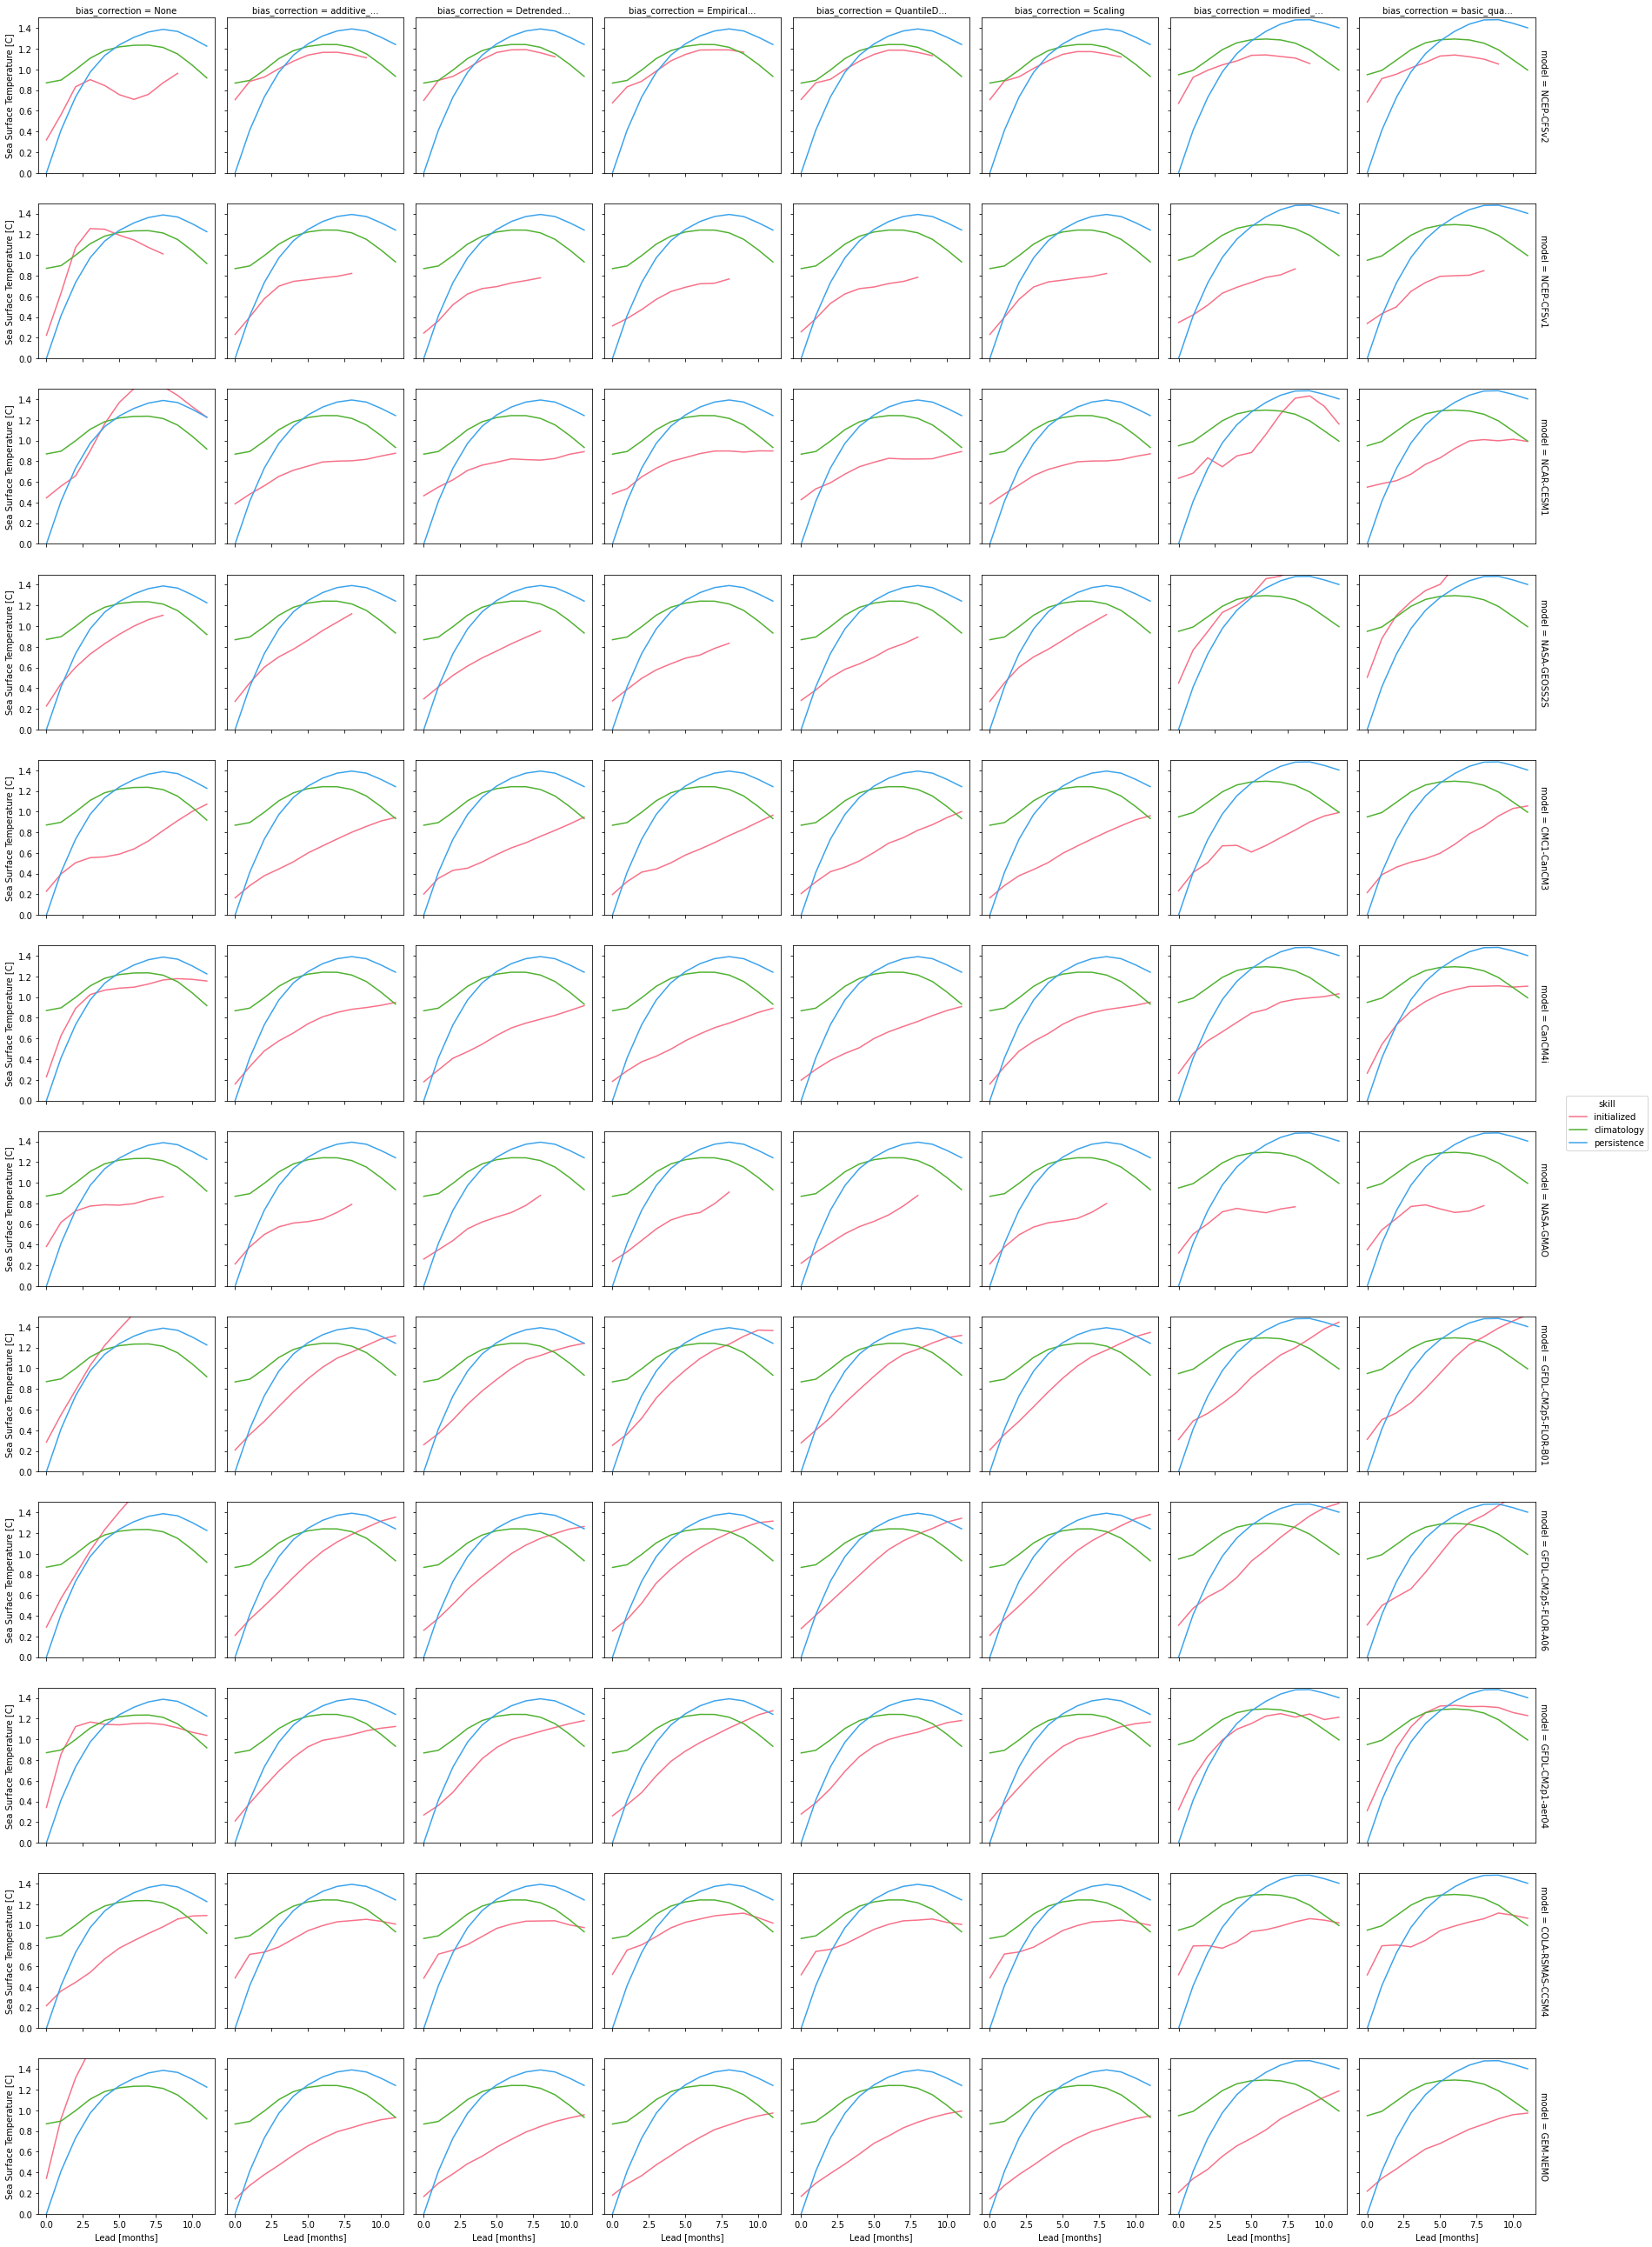

In [19]:
sns.set_palette("husl", skill_bias_reduction.skill.size)
skill_bias_reduction.plot(col="bias_correction", hue="skill", row="model")
plt.ylim([0, 1.5])

In [20]:
skill_bias_reduction.where(skill_bias_reduction.argmin("skill") == 0).notnull().sum(
    "lead"
).sel(skill="initialized", drop=True).astype(int).to_dataframe().unstack(0)

sst                                         \
bias_correction     None additive_mean DetrendedQuantileMapping   
model                                                             
NCEP-CFSv2             7             6                        6   
NCEP-CFSv1             4             8                        8   
NCAR-CESM1             2            10                       10   
NASA-GEOSS2S           7             7                        8   
CMC1-CanCM3           10            10                       10   
CanCM4i                5            10                       11   
NASA-GMAO              7             8                        8   
GFDL-CM2p5-FLOR-B01    0             8                        8   
GFDL-CM2p5-FLOR-A06    0             8                        8   
GFDL-CM2p1-aer04       5             9                        9   
COLA-RSMAS-CCSM4       9             8                        8   
GEM-NEMO               0            11                       10   

                                                                           \
bias_correction     EmpiricalQuantileMapping QuantileDeltaMapping Scaling   
model                                                                       
NCEP-CFSv2                                 5                    6       6   
NCEP-CFSv1                                 8                    8       8   
NCAR-CESM1                                10                   10      10   
NASA-GEOSS2S                               8                    8       7   
CMC1-CanCM3                               10                   10      10   
CanCM4i                                   11                   11      10   
NASA-GMAO                                  8                    8       8   
GFDL-CM2p5-FLOR-B01                        7                    8       8   
GFDL-CM2p5-FLOR-A06                        8                    8       8   
GFDL-CM2p1-aer04                           8                    9       9   
COLA-RSMAS-CCSM4                           7                    8       8   
GEM-NEMO                                  10                   10      10   

                                                      
bias_correction     modified_quantile basic_quantile  
model                                                 
NCEP-CFSv2                          6              6  
NCEP-CFSv1                          7              7  
NCAR-CESM1                          5             10  
NASA-GEOSS2S                        0              0  
CMC1-CanCM3                        11             10  
CanCM4i                             9              7  
NASA-GMAO                           7              7  
GFDL-CM2p5-FLOR-B01                 7              6  
GFDL-CM2p5-FLOR-A06                 6              5  
GFDL-CM2p1-aer04                    5              0  
COLA-RSMAS-CCSM4                    8              7  
GEM-NEMO                            9             11